# SETUP

The following blocks are to be executed first of anything else, to setup import, classes, functions and constants that are needed for all stages

In [17]:
import os
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import resnet34

from PIL import Image
from tqdm import tqdm

from logs import Logger, generate_model_checkpoint_name, generate_log_filenames

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from attention_model_MS_reg import attention_model_ms_reg
from flow_resnet import flow_resnet34
from twoStreamModel import twoStreamAttentionModel
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip, DownSampling, To1Dimension)

In [18]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
NUM_CLASSES = 61 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 1     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

RGB_PREFIX = 'model_rgb_state_dict'
FLOW_PREFIX = 'model_flow_state_dict'
JOINT_PREFIX = 'model_twoStream_state_dict'
LOG_PREFIX = 'log_stage'
VAL_LOG_PREFIX = 'val_log_stage'
DATA_DIR = '../GTEA61'
model_folder = '../saved_models'

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(true, predicted):
    true = torch.cat(true, dim=0)
    predicted =[p.to('cpu') for p in  predicted]
    predicted = torch.cat(predicted, dim=0) 
    cnf_matrix = confusion_matrix(true, predicted, normalize='true').astype(float)

    ticks = np.linspace(0, 60, num=61)
    plt.figure(figsize=(8,8))
    plt.imshow(cnf_matrix, interpolation='none', cmap='binary')
    plt.colorbar()
    plt.xticks(ticks, fontsize=6)
    plt.yticks(ticks, fontsize=6)
    plt.grid(True)
    plt.clim(0, 1)
    plt.show()

    
def generate_model_checkpoint_name(stage, n_frames, ms_block=False, loss=None, optional=''):
    name = ""
    if stage < 3:
        name += RGB_PREFIX
        if stage == 2:
            name += '_stage2'
    elif stage == 3:
        name += FLOW_PREFIX
    else:
        name += JOINT_PREFIX
    name += '_'+str(n_frames)+'frames'
    if loss is not None:
            name += '_'+loss
    if ms_block:
        name += '_msblock'
    name += optional+".pth"
    
    return name

In [20]:
# Data loader
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

val_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])

# ConvLSTM+attent+MS reg specific setup

In [21]:
STAGE = 2

MEM_SIZE = 512
SEQ_LEN = 7

In [22]:
# Prepare Pytorch train/test Datasets
test_dataset = GTEA61(DATA_DIR, split='test', transform=val_transform, seq_len=SEQ_LEN)

#print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Test Dataset: 116


In [23]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g.
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Prepare eval ConvLSTM+attent+MS reg

In [25]:
generate_model_checkpoint_name(stage=STAGE-1, n_frames=SEQ_LEN, ms_block = True)

'model_rgb_state_dict_7frames_msblock.pth'

In [28]:
best_model_file = generate_model_checkpoint_name(stage=STAGE-1, n_frames=SEQ_LEN, ms_block = True)
best_model = os.path.join(model_folder, best_model_file)
model = attention_model_ms_reg(num_classes=NUM_CLASSES, mem_size=MEM_SIZE)
model.load_state_dict(torch.load(best_model))

for params in model.parameters():
    params.requires_grad = False

model.train(False)
model.to(DEVICE)
test_samples = len(test_dataset)

# ConvLSTM+attent+MS reg evaluation

Number of samples = 116
Evaluating...
Test Accuracy = 0.862%


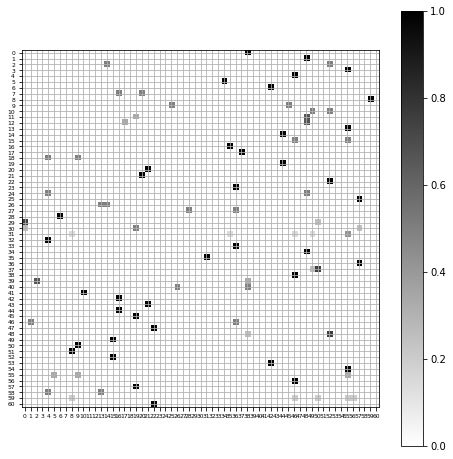

In [29]:
print('Number of samples = {}'.format(test_samples))
print('Evaluating...')
numCorr = 0
true_labels = []
predicted_labels = []

for inputs, targets in test_loader:
    inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
    labelVariable = targets.to(DEVICE)
    
    output_label, _ = model(inputVariable)
    _, predicted = torch.max(output_label.data, 1)
    numCorr += torch.sum(predicted == labelVariable.data).data.item()
    # store results in a list to plot confusion matrix later
    true_labels.append(targets)
    predicted_labels.append(predicted)
                
test_accuracy = (numCorr / test_samples) * 100
print('Test Accuracy = {:.3f}%'.format(test_accuracy))
plot_confusion_matrix(true_labels, predicted_labels)